In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
import numpy as np
import json, os

In this homework, we will explore deep networks using  PyTorch framework!
With the MNIST dataset consisting of 70000 images (28 * 28 * 1) of handwritten digits, we will train a multiple-layer perceptron network to detect the digit corresponding to the input image. 

In [78]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


#Data Loading

Run the cell below to download the dataset. 

In [114]:
import ambda
mnist_train = datasets.MNIST(root='./data', train=True, download=True,
                             transform=transforms.ToTensor()
                             ,target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

mnist_test = datasets.MNIST(root='./data', train=False, download=True,transform=transforms.ToTensor()) 


ModuleNotFoundError: ignored

In [80]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [81]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [82]:
image, label = mnist_test[0]
label

7

In [83]:
image.shape

torch.Size([1, 28, 28])

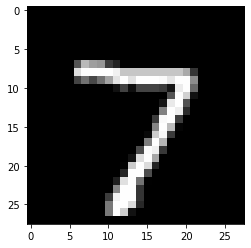

In [84]:
plt.imshow(image.reshape(28,28), cmap='gray')

#Model


The model we want to classify the MNIST dataset is a two-hidden-layer MLP with 120 and 84 units in each layer, respectively. 

Create a PyTorch model for described model and use ReLU for the activation function.




In [106]:
class MultilayerPerceptron(nn.Module):
  def __init__(self, act_fn=nn.ReLU(), input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
    """
    Inputs:
      act_fn - Object of the activation function that should be used as non-linearity in the network.
      input_size - Size of the input images in pixels
      num_classes - Number of classes we want to predict
      hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
    """
    super().__init__()
    
    # Create the network based on the specified hidden sizes
    layers = []
    layer_sizes = [input_size] + hidden_sizes
    for layer_index in range(1, len(layer_sizes)):
        layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                    act_fn]
    layers += [nn.Linear(layer_sizes[-1], num_classes), nn.LogSoftmax(dim=1)]
    self.layers = nn.ModuleList(layers) # A module list registers a list of modules as submodules (e.g. for parameters)
    
    self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes} 
    

  def forward(self, x):
    # Perform the calculation of the model to determine the prediction
    x = x.view(x.size(0), -1)
    for l in self.layers:
      x = l(x)
    return x



In [107]:
torch.manual_seed(80)
model = MultilayerPerceptron(hidden_sizes=[120, 84])
model

MultilayerPerceptron(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [ ]:
!brew install graphviz
!pip install torchviz

In [99]:
# from torchviz import make_dot
# batch = next(iter(dataloader_train))
# yhat = model(batch.text) # Give dummy batch to forward().
# make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

Answer these questions:
2. Denote the size of the weights matrix of each layer (consider the input and output layer as well). 
1. What initial values are used  ​​for the weights and biases of your model? (Do not report the specific value, we are interested in distributions that are used.)

#Training


In this section, we want to train our MLP model using the SGD algorithm. 

As we discussed in class, instead of calculating loss using the whole inputs, we break the dataset (with size $n$) into some batches of size m ($m < n$) and, at each iteration, calculate the loss of one batch and update the weights.  

Using the `DataLoader` class of the torch library, complete the cell below to batch the test and train dataset.

In [108]:
batch_size = 100

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

there are yet a couple of hyperprameters that we should define before training.

In [109]:

epochs = 10
learning_rate = 0.01 #feel free to play with this


Answer these questions:
* Prove that the **expected value** of the gradient obtained using a random batch equals the gradient of the whole dataset.

* For the dataset of size $n = $12000, if the batch size is 200, what would be the number of weight updates (or iterations) in a total of 5 epoche?


Complete the training function below, such that at each epoch:




1. For each batch:

  1. Perform feedforward
  2. Calculate loss (use cross-entropy loss)
  3. Perform backpropagation and updating weights

2. Calculate and report the training accuracy and loss for each epoch (use the average of the batch accuracy as epoch accuracy).
3. Calculate and report the test accuracy and loss for each epoch


In [110]:
#initialize loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [111]:
# Push model to device. Has to be only done once
model.to(device)

MultilayerPerceptron(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

Highly encourage you to use [this](https://github.com/tqdm/tqdm) awesome package called taqaddum to have a nice progress bar for the training process


In [112]:

def train(model, loss_function, optimizer, train_loader, test_loader, epochs):
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc  = []

  
  for epoch in tqdm(range(epochs)):
    # Set model to train mode
    # Training loop
    model.train() 
    true_preds, count = 0., 0
    epoch_loss = 0.0
    # targets = targets.type(torch.LongTensor)
    for data_inputs, data_labels in train_loader:
        
      ## Step 1: Move input data to device (only strictly necessary if we use GPU)
      data_inputs = data_inputs.to(device)
      data_labels = data_labels.to(device)
      
      ## Step 2: Run the model on the input data
      preds = model(data_inputs.view(len(data_inputs),-1))
      # print(preds[0])

      preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
      
      ## Step 3: Calculate the loss
      # print(data_labels )
      # print(preds[0])

      loss = loss_function(preds, data_labels)
      
      ## Step 4: Perform backpropagation
      # Before calculating the gradients, we need to ensure that they are all zero. 
      # The gradients would not be overwritten, but actually added to the existing ones.
      optimizer.zero_grad() 
      # Perform backpropagation
      loss.backward()
      
      ## Step 5: Update the parameters
      optimizer.step()


      epoch_loss+=loss.item()
      true_preds += (preds.argmax(dim=-1) == data_labels).sum().item()
      count += data_labels.shape[0]
    train_losses.append(loss.item()/len(data_inputs))
    t_acc = true_preds / count
    train_acc.append(t_acc)

    model.eval()
    ttrue_preds, count = 0., 0
    epoch_loss = 0.0
    for data_inputs, data_labels in test_loader:
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
        with torch.no_grad():
            preds = model(data_inputs).argmax(dim=-1)
            loss = loss_function(preds, data_labels)
            epoch_loss+=loss.item()

            true_preds += (preds == data_labels).sum().item()
            count += data_inputs.shape[0]
    test_losses.append(loss.item()/len(data_inputs))
    test_acc = true_preds / count


    


    #todo



    return train_losses, train_acc, test_acc, test_losses

In [113]:
train_losses, train_acc, test_acc, test_losses = train(model, loss_function, optimizer, train_loader, test_loader, epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: ignored

Now plot the training results (one plot for test and training accuracy and one for the loss)

In [ ]:
#plot loss


In [ ]:
#plot accuracy


Based on your plots, answer these questions:
1. Compare the training and test loss
2. Did your model become overfitted? Why?
3. Why your training loss is not a  decreasing function with respect to #epoch?

Repeat the training process for 5 diffrent learning rate and compare the results.

In [ ]:
#to do

#Vanishing Gradient

In this section, we want to see the vanishing gradient problem.

Create two separate models with 5 hidden layers of size [100, 100, 80, 50, 30],
one of them uses ReLU as an activation function and the other one uses Sigmoid.


In [ ]:
class MLP_relu(nn.Module):

  #todo

In [ ]:
class MLP_sigmoid(nn.Module):

  #todo


In [ ]:
#instantiate the models


Modify the train function to save the gradient and weights of each layer, every epoch. Return these values as well. 

In [ ]:
def train(model, loss_function, optimizer, train_loader, test_loader, epochs):

    train_losses = []
    test_losses = []
    train_acc = []
    test_acc  = []
    weights = {'H1':[], 'H2':[], 'H3':[],'H4':[], 'H5':[]}
    biases = {'H1':[], 'H2':[], 'H3':[],'H4':[], 'H5':[]}
    grads = {'H1':[], 'H2':[], 'H3':[],'H4':[], 'H5':[]}


    #todo



    return train_losses, train_acc, test_acc, test_losses, weights, grads

Now, train the sigmoid and relu model.

In [ ]:
#training

In [ ]:
#plot loss


In [ ]:
#plot accuracy

As you can see, the sigmoid model is not good at all. Based on the following plots explain why.

For each layer, calculate the mean and std (standard deviation) of all its weights and plot these values ​​vs #epochs. Repeat the same for the grads.

You should do:

* Calculate the average weight of each hidden layer in each epoch.
* Calculate the std for the weight of each hidden layer in each epoch.

* Calculate the average grads of each hidden layer in each epoch.
* Calculate the std for the grads of each hidden layer in each epoch.

Plot all of them for both models (use subplot to compare two models' results).






In [ ]:
#calcute means and stds

In [ ]:
#plot weights mean for the both models

In [ ]:
#plot weights std for the both models

In [ ]:
#plot grads mean for the both models

In [ ]:
#plot grads std for the both models

Good Luck!